In [1]:
#载入本章学习必要的库

import numpy as np
import keras
import matplotlib.pyplot as plt


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation,Conv2D,MaxPooling2D
from keras import layers, optimizers

Using TensorFlow backend.
D:\Users\Anaconda3\envs\DL_interview\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\Anaconda3\envs\DL_interview\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\Anaconda3\envs\DL_interview\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\Anaconda3\envs\DL_interview\lib\sit

In [2]:
#载入cifar10数据集
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:

#对数据进行归一化处理
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255



#对标签进行独热编码
Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)






In [4]:
#只选取头200张图片来训练
X_train=X_train[0:200]
Y_train=Y_train[0:200]

X_test=X_test[0:1000]
Y_test=Y_test[0:1000]


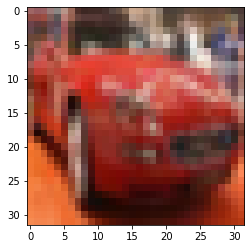

In [5]:

plt.imshow(X_train[5,:,:,:])

In [6]:
# 进行数据增强


datagen = ImageDataGenerator(
                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=True)  # randomly flip images


datagen.fit(X_train)


In [17]:


#导入预训练好权重的残差神经网络RESNET50


res_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

res_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


D:\Users\Anaconda3\envs\env_cv\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
#搭建模型
model = Sequential()

#注意要对图片进行Upsampling
model.add(layers.UpSampling2D((2,2), input_shape=(32, 32, 3)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
#接上模型和新的层
model.add(res_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))
#model.build()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 131072)            524288    
___________________________

In [20]:
#定义优化器和编译模型

adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])



In [22]:

#训练模型，用测试集做VALIDATION数据直接查看测试结果
batch_size=20
model.fit_generator(datagen.flow(X_train, Y_train,batch_size=batch_size),
                                                steps_per_epoch=X_train.shape[0] // batch_size,
                                                epochs=1,
                                                validation_data=(X_test, Y_test))


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10/10 [==============================] - 763s 76s/step - loss: 0.3975 - acc: 0.8885 - val_loss: 0.3346 - val_acc: 0.8977
